In [1]:
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import pairwise_distances
import haccytrees.mergertrees
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import hdbscan
import math
import sklearn

In [2]:
blobs, labels = make_blobs(n_samples=2000, n_features=10)

In [3]:
pd.DataFrame(blobs).head()

,0,1,2,3,4,5,6,7,8,9
0,4.427017,-4.839667,-1.804068,2.437842,-0.098548,-8.209638,-2.383927,0.675181,-7.526627,2.004671
1,2.670765,-4.272208,-1.781412,3.294802,2.303560,-6.061481,-2.617211,-3.786863,-5.651896,3.885730
2,3.338765,-3.355413,-2.262560,1.229880,0.844572,-6.716063,-1.992009,-0.050441,-6.298739,1.620076
3,3.049783,-3.330857,-2.079419,3.466488,0.572332,-6.604847,-0.509126,-0.819645,-4.349850,0.430971
4,3.911167,9.059984,1.759782,1.336564,-5.297942,10.505159,2.158721,-3.437538,-9.192164,-0.058138


In [4]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(blobs)

HDBSCAN()

In [5]:
clusterer.labels_

array([2, 2, 2, ..., 1, 1, 0])

In [6]:
clusterer.labels_.max()

2

In [7]:
clusterer.probabilities_

array([0.5930094 , 0.60395937, 0.83807596, ..., 0.46604609, 0.66425667,
       0.76523871])

Change up the metrics

In [8]:
clusterer = hdbscan.HDBSCAN(metric='manhattan')
clusterer.fit(blobs)
clusterer.labels_

array([1, 1, 1, ..., 2, 2, 0])

In [9]:
hdbscan.dist_metrics.METRIC_MAPPING

{'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dist_metrics.MinkowskiDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'seuclidean': hdbscan.dist_metrics.SEuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'wminkowski': hdbscan.dist_metrics.WMinkowskiDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'rogerst

In [10]:
distance_matrix = pairwise_distances(blobs)
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(distance_matrix)
clusterer.labels_

array([1, 1, 1, ..., 0, 0, 2])

### Michael's code (to play around with)
- note that hdbscan does not know about periodic boundary conditions. it just uses eulerian distances by default, so the cluster associations across domain boundaries is incorrect
- however, hdbscan accepts a distance matrix of shape (N, N) where N is the number of halos in our case, and each entry in the matrix d_ij is the distance from halo h_i to halo h_j
- you could create this matrix manually (accounting for periodic boundaries) and feed it to hdbscan in order to get correct results at the boundaries

In [11]:
forest, progenitor_array = haccytrees.mergertrees.read_forest('/data/a/cpac/mbuehlmann/LJSV/forest/m000p.forest.hdf5',
                                                              'LastJourneySV', nchunks=1, chunknum=0, mass_threshold = 2.7*10**11, include_fields = ["tree_node_mass", "snapnum", "fof_halo_tag", "sod_halo_cdelta", "fof_halo_center_x", "fof_halo_center_y", "fof_halo_center_z"])

In [51]:
# something like this to get all positions of halos at z=0 and more than 1e12Msun/h:
mask = forest['snapnum'] == 100
mask &= forest['tree_node_mass'] > 1e12
pos = np.array([forest[f'fof_halo_center_{x}'][mask] for x in "xyz"]).T
print(len(mask[mask]))
print(len(pos))
print(pos)

61500
61500
[[ 23.99833    6.901598  49.610268]
 [ 24.826807  18.101597  55.16124 ]
 [ 25.542326  17.558128  52.037895]
 ...
 [232.38635  243.3956   224.70914 ]
 [227.44342  219.11325  206.36346 ]
 [222.30594  216.29126  198.0361  ]]


In [27]:
# then, for the default parameters:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(pos)
labels = clusterer.labels_ # max gives us the number of clusters - 1 (so 2015 means there are 2016 unique clusters)
score = clusterer.probabilities_ # Why are there zeros?

[0.88410578 0.         0.         ... 0.72724815 1.         0.        ]


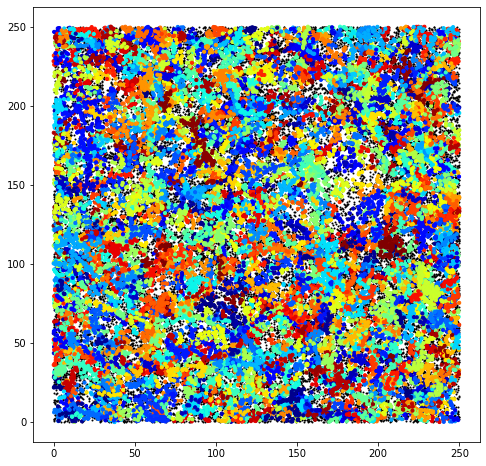

In [14]:
# and to plot (in 2d):
fig, ax = plt.subplots(figsize=(8, 8))
# mask of halos that are associated with a cluster
mask = labels >= 0
# randomize labels, normalize to [0, 1]
color = np.random.permutation(np.max(labels)+1)[labels]/(np.max(labels))
ax.scatter(pos[~mask, 0], pos[~mask, 1], c='black', s=1)
ax.scatter(pos[mask, 0], pos[mask, 1], c=color[mask], alpha=1, s=10, cmap='jet')
#ax.scatter(pos[mask, 0], pos[mask, 1], c=color[mask], alpha=0.1+0.9*score[mask]**10, s=10, cmap='jet')

## Building a distance matrix (by hand)

In [29]:
# Arbitrary example
distance_matrix = pairwise_distances(blobs)
print(distance_matrix)
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(distance_matrix)
clusterer.labels_

[[ 0.          6.44540813  3.24232679 ... 22.26595886 23.16639949
  21.94463064]
 [ 6.44540813  0.          5.31437595 ... 21.21719548 22.52305171
  21.08448449]
 [ 3.24232679  5.31437595  0.         ... 20.56202229 21.5906415
  20.49694959]
 ...
 [22.26595886 21.21719548 20.56202229 ...  0.          5.7592019
  25.5781191 ]
 [23.16639949 22.52305171 21.5906415  ...  5.7592019   0.
  27.41965603]
 [21.94463064 21.08448449 20.49694959 ... 25.5781191  27.41965603
   0.        ]]


array([1, 1, 1, ..., 0, 0, 2])

In [56]:
# however, hdbscan accepts a distance matrix of shape (N, N) where N is the number of halos in our case, and each entry in the 
# matrix d_ij is the distance from halo h_i to halo h_j.
##### Just 2D, not considering z coords?
# you could create this matrix manually (accounting for periodic boundaries) and feed it to hdbscan in order to 
# get correct results at the boundaries
N = len(mask[mask]) # number of halos
N = 100
distances = np.zeros((N, N, N))
print(d_array.shape)
#[[[d_array[i,j,k] = np.sqrt(pos[i,0]**2 + pos[j,1]**2 + pos[k,2]) for k in range(0,N)] for j in range(0,N)] for i in range(0,N)] # how far away from each other?
for i in range(0,N):
    for j in range(0,N):
        for k in range(0,N):
            distances[i,j,k] = np.sqrt(pos[i,0]**2 + pos[j,1]**2 + pos[k,2])
print(distances[0])
print(len(distances[0][0]))
print(distances[0][0])

(100, 100, 100)
[[25.94536808 26.05212269 25.99210943 ... 25.00505946 25.4073833
  26.14249087]
 [30.87390286 30.96366984 30.91319307 ... 30.08801675 30.4231964
  31.03974198]
 [30.55843487 30.64912582 30.59813016 ... 29.76422039 30.10300554
  30.72597672]
 ...
 [42.86422081 42.92892263 42.89252911 ... 42.301682   42.54073844
  42.98382405]
 [33.30101924 33.38426058 33.33744906 ... 32.57374335 32.88359596
  33.45482904]
 [33.74762252 33.82976497 33.78357076 ... 33.03018164 33.33579198
  33.89940604]]
100
[25.94536808 26.05212269 25.99210943 25.44461043 25.64445123 26.15921081
 25.15256442 26.09020307 25.87810811 25.6497054  25.75311616 26.09857324
 25.25717772 25.0506859  25.80744349 26.18127412 25.97649084 25.08111807
 25.76434046 25.10470137 25.97426623 25.34814054 26.09251502 25.44950756
 25.66393423 25.45442072 26.09698211 25.71953218 25.84751406 25.89554603
 25.45789984 26.16806198 26.13004988 25.03078839 25.93186371 25.38980494
 25.00859402 25.01784024 25.56010064 25.50188559 25.